# 1. Загрузка изображений и предварительный обзор

Задача: научиться находить контуры кур на изображении.

In [1]:
!pip install opencv-python

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
img = cv2.imread('/kaggle/input/chickens-cv/dataset/train_aug/images/20221115150231_09_jpg.rf.9d26c5bf62f4e11109768d1af73c5bd8.jpg')

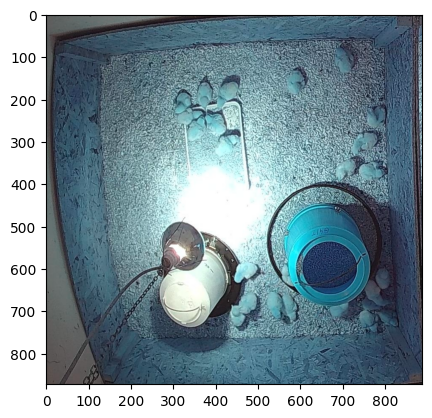

In [5]:
plt.imshow(img)
plt.show()

Посмотрим на изображение с меткой

In [6]:
seg_data = []
with open('/kaggle/input/chickens-cv/dataset/train_aug/labels/20221115150231_09_jpg.rf.9d26c5bf62f4e11109768d1af73c5bd8.txt', 'r') as f:
    seg_data = f.readlines()

In [15]:
len(seg_data)

25

In [8]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

img_conturs = img.copy()

In [22]:
overlay = img.copy()

for i, seg in enumerate(seg_data):
    coords = list(map(float, seg.split()[1:]))
    
    points = []
    for j in range(0, len(coords), 2):
        x = int(coords[j] * w)
        y = int(coords[j + 1] * h)
        points.append([x, y])
    
    points = np.array(points, dtype=np.int32)
    
    cv2.polylines(img_conturs, [points], isClosed=True, 
                 color=(255, 0, 0), thickness=3)
    
    cv2.fillPoly(overlay, [points], (255, 0, 0))
    
    if len(points) > 0:
        cv2.putText(img_conturs, f'{i}', tuple(points[0]), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

alpha = 0.3
img_conturs = cv2.addWeighted(overlay, alpha, img_conturs, 1 - alpha, 0)

(-0.5, 888.5, 872.5, -0.5)

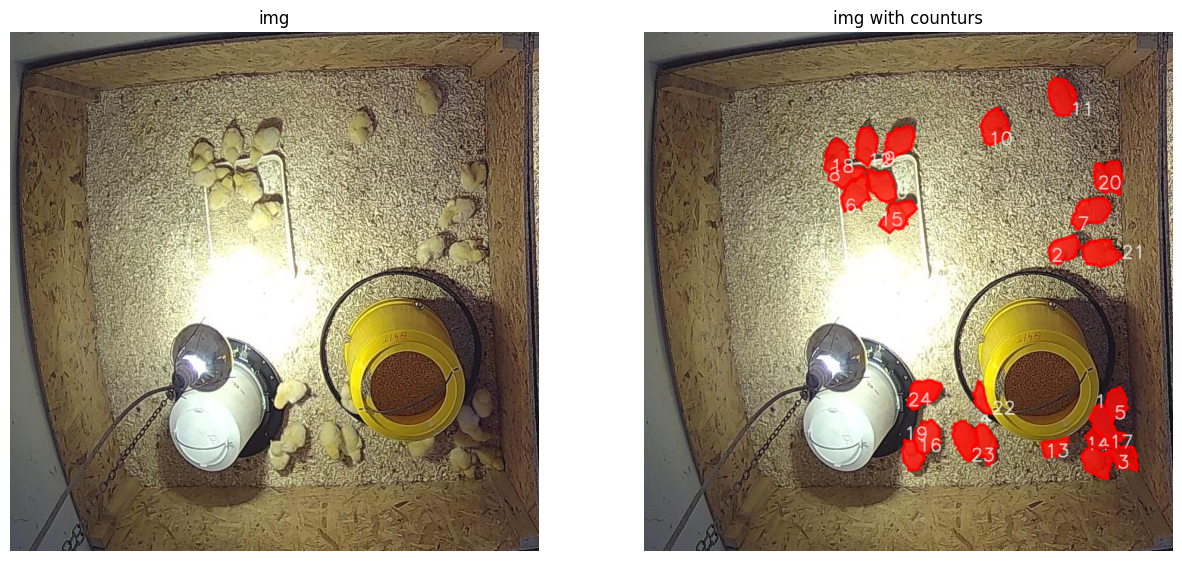

In [23]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('img')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_conturs)
plt.title('img with counturs')
plt.axis('off')

# 2.Аугментация изображений

Изображения из данного набора разделены на 3 категории: train, test, val, в соотношении 0.8, 0.1, 0.1 соотвественно. Для этого использовался скрипт из файла: prepare_dataset.py. Изображения в данном датасете уже аументированы, для этого использовался скрипт приведенный ниже, из файла: img_aug.py

Скрипт ниже запускать не нужно!

In [ ]:
import numpy as np
from pathlib import Path

def augment_image(image):

    rows, cols = image.shape[:2]
    
    aug_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(aug_img)
    
    h += np.random.randint(0, 100, size=(rows, cols), dtype=np.uint8)
    s += np.random.randint(0, 20, size=(rows, cols), dtype=np.uint8)
    v += np.random.randint(0, 10, size=(rows, cols), dtype=np.uint8)
    
    aug_img = cv2.merge([h, s, v])
    aug_img = cv2.cvtColor(aug_img, cv2.COLOR_HSV2RGB)
    
    blur_val = np.random.randint(5, 12)
    aug_img = cv2.blur(aug_img, (blur_val, blur_val))
    
    alpha = np.random.uniform(0.8, 1.2)
    beta = np.random.randint(-30, 30)
    aug_img = cv2.convertScaleAbs(aug_img, alpha=alpha, beta=beta)
    
    noise = np.random.normal(0, 0.2, image.shape).astype(np.uint8)
    aug_img = cv2.add(aug_img, noise)
    
    return aug_img

def augment_dataset(images_dir, labels_dir, output_dir, num_augmentations=1):

    images_dir = Path(images_dir)
    labels_dir = Path(labels_dir)
    output_dir = Path(output_dir)
    
    aug_images_dir = output_dir / 'images'
    aug_labels_dir = output_dir / 'labels'
    aug_images_dir.mkdir(parents=True, exist_ok=True)
    aug_labels_dir.mkdir(parents=True, exist_ok=True)
    
    image_files = list(images_dir.glob("*.jpg"))
    
    print(f"{len(image_files)} images find")
    
    for i, image_path in enumerate(image_files):
        print(f"processing {i+1}/{len(image_files)}: {image_path.name}")
        
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label_path = labels_dir / f"{image_path.stem}.txt"
        
        output_image_path = aug_images_dir / image_path.name
        cv2.imwrite(str(output_image_path), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        if label_path.exists():
            output_label_path = aug_labels_dir / f"{image_path.stem}.txt"
            output_label_path.write_text(label_path.read_text())
        
        for aug_idx in range(num_augmentations):
            aug_image = augment_image(image)
            
            aug_image_name = f"{image_path.stem}_aug_{aug_idx+1}{image_path.suffix}"
            aug_image_path = aug_images_dir / aug_image_name
            cv2.imwrite(str(aug_image_path), cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
            
            if label_path.exists():
                aug_label_name = f"{image_path.stem}_aug_{aug_idx+1}.txt"
                aug_label_path = aug_labels_dir / aug_label_name
                aug_label_path.write_text(label_path.read_text())
    
    print("Augmentation is complete")

if __name__ == "__main__":
    images_dir = Path('dataset/val/images')
    labels_dir = Path('dataset/val/labels')
    output_dir = Path('augmented_val')
    
    augment_dataset(images_dir, labels_dir, output_dir, num_augmentations=1)

# 3. Создание модели для сегментации

В качестве бейзлайна будем использовать модель YOLO. Одним из главных преимущест данной модели является его высокая скорость и приемлемая точность.

In [24]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninst

In [25]:
from ultralytics import YOLO
import torch
from pathlib import Path

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [26]:
dataset_path = "/kaggle/input/chickens-cv/dataset/data.yaml"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Used device: {device}")

Used device: cuda


Загрузим предобученную модель yolov8n-seg и обучим его на наших данных. Для этого создадим файл data.yaml, который будет содержаить информацию о местонахождении изображений для модели.


In [27]:
model = YOLO('yolov8n-seg.pt')

In [28]:
results = model.train(
    data=dataset_path,           
    epochs=50,                   
    imgsz=640,                   
    batch=16,                    
    device=device,              
    patience=10,                 
    save=True,                   
    project='runs',              
    name='chicken_segmentation', 
    exist_ok=True,               
    verbose=True                 
)


Ultralytics 8.3.195 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/chickens-cv/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=chicken_segmentation, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plot

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        228       3024      0.986      0.985      0.991      0.928      0.985      0.984      0.991      0.904
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to /kaggle/working/runs/chicken_segmentation


In [29]:
print(f"mAP@0.5:     {results.box.map50:.4f}")
print(f"mAP@0.5:0.95: {results.box.map:.4f}")
print(f"Precision:   {results.box.mp:.4f}")
print(f"Recall:      {results.box.mr:.4f}")

mAP@0.5:     0.9909
mAP@0.5:0.95: 0.9279
Precision:   0.9858
Recall:      0.9846


In [30]:
print(f"Seg mAP@0.5: {results.seg.map50:.4f}")
print(f"Seg mAP@0.5:0.95: {results.seg.map:.4f}")


Seg mAP@0.5: 0.9908
Seg mAP@0.5:0.95: 0.9038


Давайте посмотрим на графики обучения

In [32]:
import pandas as pd

In [33]:
res_df = pd.read_csv('/kaggle/working/runs/chicken_segmentation/results.csv')

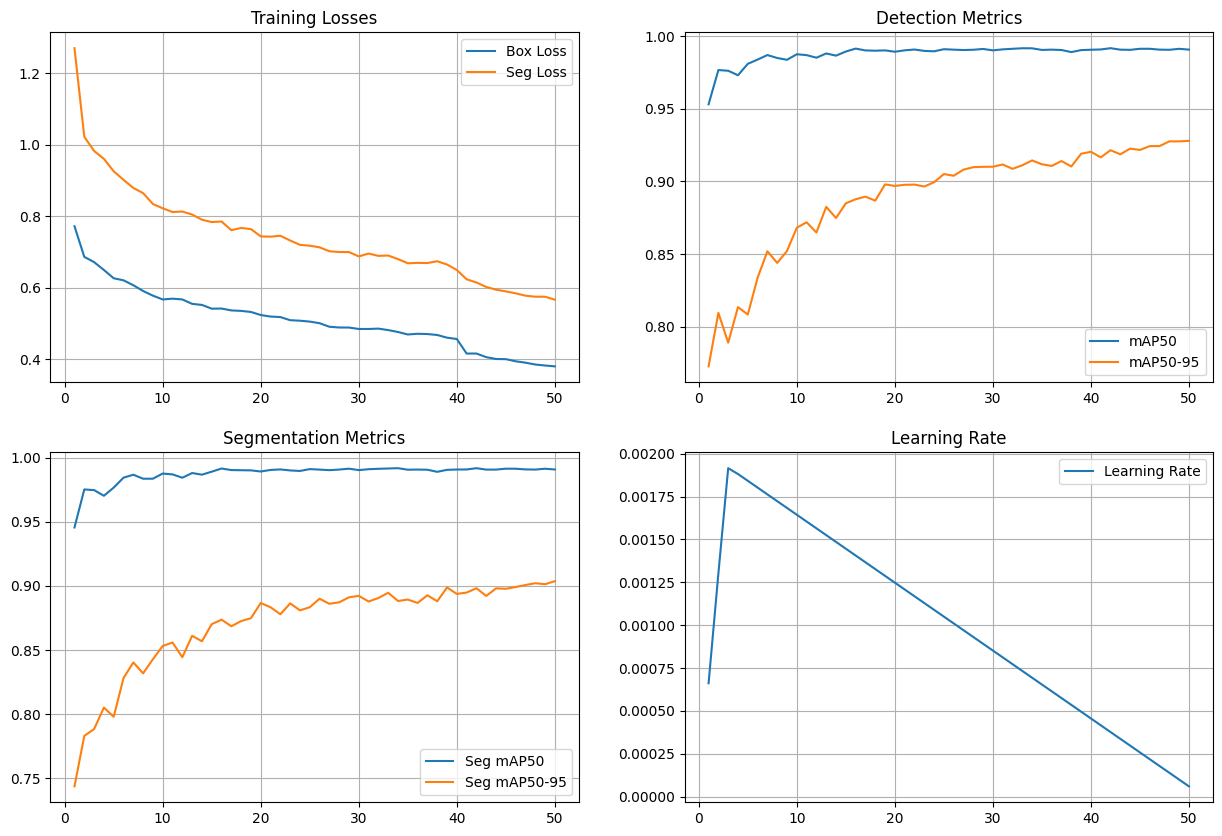

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# loss
if 'train/box_loss' in res_df.columns:
    axes[0, 0].plot(res_df['epoch'], res_df['train/box_loss'], label='Box Loss')
if 'train/seg_loss' in res_df.columns:
    axes[0, 0].plot(res_df['epoch'], res_df['train/seg_loss'], label='Seg Loss')
axes[0, 0].set_title('Training Losses')
axes[0, 0].legend()
axes[0, 0].grid(True)

# detection
if 'metrics/mAP50(B)' in res_df.columns:
    axes[0, 1].plot(res_df['epoch'], res_df['metrics/mAP50(B)'], label='mAP50')
if 'metrics/mAP50-95(B)' in res_df.columns:
    axes[0, 1].plot(res_df['epoch'], res_df['metrics/mAP50-95(B)'], label='mAP50-95')
axes[0, 1].set_title('Detection Metrics')
axes[0, 1].legend()
axes[0, 1].grid(True)

# segmentation
if 'metrics/mAP50(M)' in res_df.columns:
    axes[1, 0].plot(res_df['epoch'], res_df['metrics/mAP50(M)'], label='Seg mAP50')
if 'metrics/mAP50-95(M)' in res_df.columns:
    axes[1, 0].plot(res_df['epoch'], res_df['metrics/mAP50-95(M)'], label='Seg mAP50-95')
axes[1, 0].set_title('Segmentation Metrics')
axes[1, 0].legend()
axes[1, 0].grid(True)

# lr
if 'lr/pg0' in res_df.columns:
    axes[1, 1].plot(res_df['epoch'], res_df['lr/pg0'], label='Learning Rate')
    axes[1, 1].set_title('Learning Rate')
    axes[1, 1].legend()
    axes[1, 1].grid(True)


# 4. Тестирование модели 

In [52]:
test_images = list(Path("/kaggle/input/chickens-cv/dataset/test_aug/images").glob("*.jpg"))[:5]

if test_images:
    for img_path in test_images:
        print(f"{img_path.name}")
        results = model(str(img_path))
        results[0].save(f"test_result_{img_path.stem}.jpg")

Pen6_2021-07-28_01-28-50_nondiseased_jpg.rf.c9541d6c22ceef5438e9281b4b981165.jpg

image 1/1 /kaggle/input/chickens-cv/dataset/test_aug/images/Pen6_2021-07-28_01-28-50_nondiseased_jpg.rf.c9541d6c22ceef5438e9281b4b981165.jpg: 640x640 9 chickens, 9.6ms
Speed: 3.4ms preprocess, 9.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Pen2_2021-07-07_13-39-48_diseased_jpg.rf.170647226d10f19e6845ac8a8983b623.jpg

image 1/1 /kaggle/input/chickens-cv/dataset/test_aug/images/Pen2_2021-07-07_13-39-48_diseased_jpg.rf.170647226d10f19e6845ac8a8983b623.jpg: 640x640 9 chickens, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
image12_9_png.rf.ed39d78ccf2431f4f113f249014004a7.jpg

image 1/1 /kaggle/input/chickens-cv/dataset/test_aug/images/image12_9_png.rf.ed39d78ccf2431f4f113f249014004a7.jpg: 384x640 27 chickens, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)
Pen6_2021-06-19_21-49

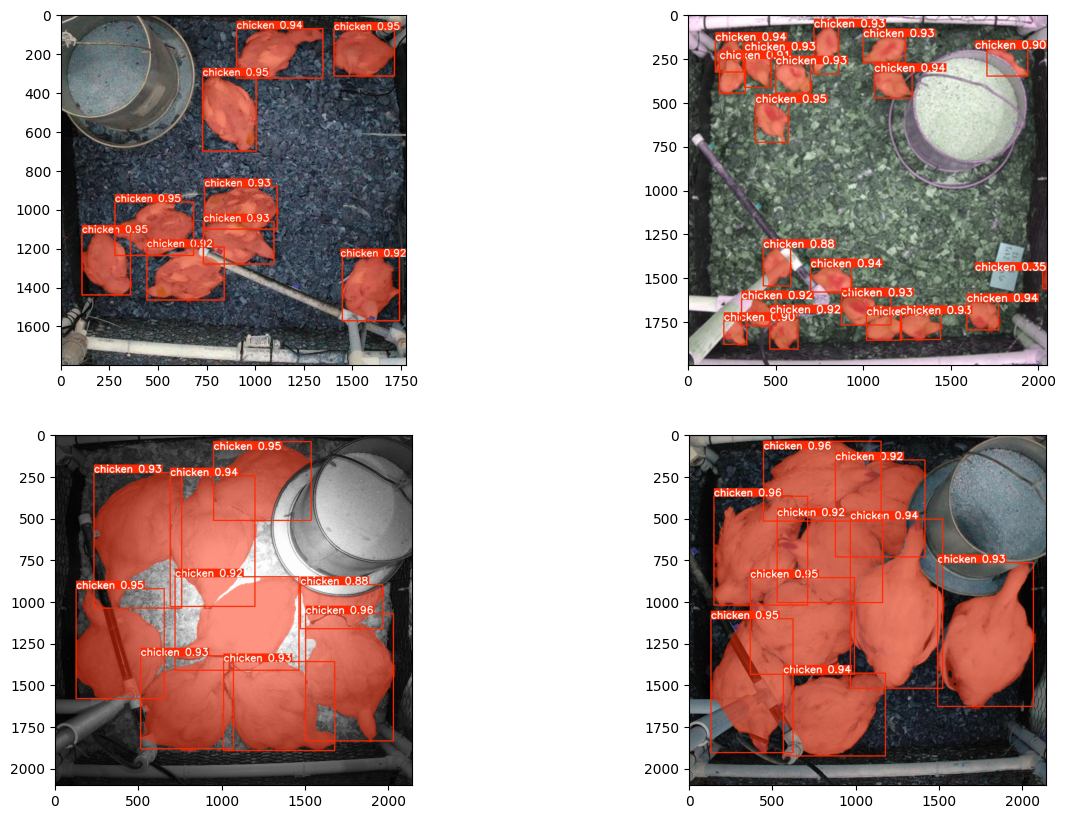

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].imshow(cv2.imread('/kaggle/working/test_result_Pen2_2021-07-07_13-39-48_diseased_jpg.rf.170647226d10f19e6845ac8a8983b623.jpg'))
axes[0,1].imshow(cv2.imread('/kaggle/working/test_result_Pen6_2021-06-19_21-49-45_nondiseased_jpg.rf.477d15183025bd440cad69b8d877761c_aug_1.jpg'))
axes[1,0].imshow(cv2.imread('/kaggle/working/test_result_Pen6_2021-07-28_01-28-50_nondiseased_jpg.rf.c9541d6c22ceef5438e9281b4b981165.jpg'))
axes[1,1].imshow(cv2.imread('/kaggle/working/test_result_Pen6_2021-07-31_20-52-57_nondiseased_jpg.rf.e800f1e12aa45a9afbc8c37c4b3ddbb3.jpg'))
plt.show()

Получили достаточно точные маски.